In [2]:
# Step 1: Install dependencies
!pip install -q kagglehub pandas scikit-learn seaborn matplotlib

# Step 2: Download dataset
import kagglehub

# Download latest version of CERT Insider Threat dataset
path = kagglehub.dataset_download("nitishabharathi/cert-insider-threat")
print("Path to dataset files:", path)


Path to dataset files: /kaggle/input/cert-insider-threat


In [3]:
import os

# Check what's actually inside the downloaded dataset folder
for root, dirs, files in os.walk(path):
    for f in files:
        print("Found file:", f)



Found file: psychometric.csv
Found file: email.csv


In [4]:
import pandas as pd
email_path = os.path.join(path, "email.csv")
email_df = pd.read_csv(email_path)

print(email_df.head())
print(email_df.columns)


                         id                 date     user       pc  \
0  {R3I7-S4TX96FG-8219JWFF}  01/02/2010 07:11:45  LAP0338  PC-5758   
1  {R0R9-E4GL59IK-2907OSWJ}  01/02/2010 07:12:16  MOH0273  PC-6699   
2  {G2B2-A8XY58CP-2847ZJZL}  01/02/2010 07:13:00  LAP0338  PC-5758   
3  {A3A9-F4TH89AA-8318GFGK}  01/02/2010 07:13:17  LAP0338  PC-5758   
4  {E8B7-C8FZ88UF-2946RUQQ}  01/02/2010 07:13:28  MOH0273  PC-6699   

                                                  to  \
0  Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...   
1                        Odonnell-Gage@bellsouth.net   
2                         Penelope_Colon@netzero.com   
3                          Judith_Hayden@comcast.net   
4  Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...   

                                cc                          bcc  \
0  Nathaniel.Hunter.Heath@dtaa.com                          NaN   
1                              NaN                          NaN   
2                              NaN       

anomaly
0    2603679
1      26300
Name: count, dtype: int64


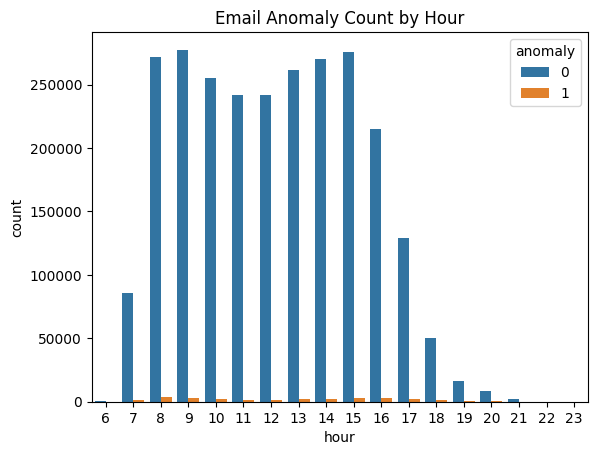

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
email_df = pd.read_csv(os.path.join(path, "email.csv"))

# Convert date to datetime
email_df['date'] = pd.to_datetime(email_df['date'])

# Feature 1: Hour of the day
email_df['hour'] = email_df['date'].dt.hour

# Feature 2: Number of 'to' recipients
email_df['to_count'] = email_df['to'].apply(lambda x: len(str(x).split(';')))

# Feature 3: CC count
email_df['cc_count'] = email_df['cc'].apply(lambda x: len(str(x).split(';')) if pd.notna(x) else 0)

# Feature 4: BCC count
email_df['bcc_count'] = email_df['bcc'].apply(lambda x: len(str(x).split(';')) if pd.notna(x) else 0)

# Feature 5: Size and attachments (already numerical)
# Feature 6: User (encoded)
le_user = LabelEncoder()
email_df['user_encoded'] = le_user.fit_transform(email_df['user'])

# Final features
features = ['hour', 'to_count', 'cc_count', 'bcc_count', 'size', 'attachments', 'user_encoded']
X = email_df[features]

# Isolation Forest for anomaly detection
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
email_df['anomaly'] = model.fit_predict(X)

# -1 = anomaly, 1 = normal
email_df['anomaly'] = email_df['anomaly'].map({1: 0, -1: 1})

print(email_df['anomaly'].value_counts())  # Check how many anomalies

# Visualize anomalies
sns.countplot(x='hour', hue='anomaly', data=email_df)
plt.title("Email Anomaly Count by Hour")
plt.show()


In [6]:
# Count number of anomalies per user
anomaly_counts = email_df[email_df['anomaly'] == 1]['user'].value_counts().reset_index()
anomaly_counts.columns = ['user', 'anomaly_count']
print(anomaly_counts.head())


      user  anomaly_count
0  ATE0869            779
1  WBC0192            550
2  ZDW0859            544
3  CSH0626            441
4  CAB0614            414


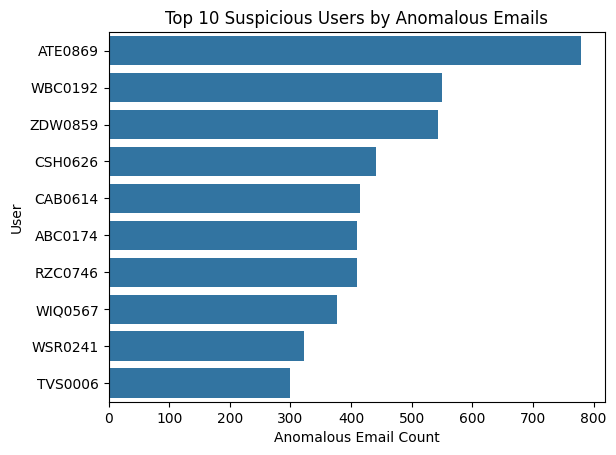

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

top_suspicious = anomaly_counts.head(10)
sns.barplot(data=top_suspicious, x='anomaly_count', y='user')
plt.title("Top 10 Suspicious Users by Anomalous Emails")
plt.xlabel("Anomalous Email Count")
plt.ylabel("User")
plt.show()


In [8]:
# Load psychometric.csv
psych_df = pd.read_csv(os.path.join(path, "psychometric.csv"))

# Merge using: email_df['user'] and psych_df['user_id']
merged_df = pd.merge(email_df, psych_df, left_on='user', right_on='user_id', how='left')

# View merged result
merged_df.head()



,id,date,user,pc,to,cc,bcc,from,size,attachments,...,bcc_count,user_encoded,anomaly,employee_name,user_id,O,C,E,A,N
0,{R3I7-S4TX96FG-8219JWFF},2010-01-02 07:11:45,LAP0338,PC-5758,Dean.Flynn.Hines@dtaa.com;Wade_Harrison@lockhe...,Nathaniel.Hunter.Heath@dtaa.com,NaN,Lynn.Adena.Pratt@dtaa.com,25830,0,...,0,588,0,Lynn Adena Pratt,LAP0338,42,23,33,45,31
1,{R0R9-E4GL59IK-2907OSWJ},2010-01-02 07:12:16,MOH0273,PC-6699,Odonnell-Gage@bellsouth.net,NaN,NaN,MOH68@optonline.net,29942,0,...,0,675,0,Macaulay Otto Hopkins,MOH0273,39,40,47,50,26
2,{G2B2-A8XY58CP-2847ZJZL},2010-01-02 07:13:00,LAP0338,PC-5758,Penelope_Colon@netzero.com,NaN,NaN,Lynn_A_Pratt@earthlink.net,28780,0,...,0,588,0,Lynn Adena Pratt,LAP0338,42,23,33,45,31
3,{A3A9-F4TH89AA-8318GFGK},2010-01-02 07:13:17,LAP0338,PC-5758,Judith_Hayden@comcast.net,NaN,NaN,Lynn_A_Pratt@earthlink.net,21907,0,...,0,588,0,Lynn Adena Pratt,LAP0338,42,23,33,45,31
4,{E8B7-C8FZ88UF-2946RUQQ},2010-01-02 07:13:28,MOH0273,PC-6699,Bond-Raymond@verizon.net;Alea_Ferrell@msn.com;...,NaN,Odonnell-Gage@bellsouth.net,MOH68@optonline.net,17319,0,...,1,675,0,Macaulay Otto Hopkins,MOH0273,39,40,47,50,26


In [9]:
# Add Big Five traits to your feature set
trait_columns = ['O', 'C', 'E', 'A', 'N']

# Fill missing values (if any)
merged_df[trait_columns] = merged_df[trait_columns].fillna(merged_df[trait_columns].mean())

# Add to existing features
features_extended = ['hour', 'to_count', 'cc_count', 'bcc_count', 'size', 'attachments', 'user_encoded'] + trait_columns
X_extended = merged_df[features_extended]

# Re-run Isolation Forest
from sklearn.ensemble import IsolationForest

model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
merged_df['anomaly'] = model.fit_predict(X_extended)
merged_df['anomaly'] = merged_df['anomaly'].map({1: 0, -1: 1})

print("Anomalies Detected:")
print(merged_df['anomaly'].value_counts())


Anomalies Detected:
anomaly
0    2603679
1      26300
Name: count, dtype: int64


In [10]:
# Group by user to count anomalies
user_anomalies = merged_df.groupby('user')['anomaly'].sum().sort_values(ascending=False).reset_index()

# Top 10 suspicious users
print("\nTop 10 Suspicious Users:")
print(user_anomalies.head(10))



Top 10 Suspicious Users:
      user  anomaly
0  WIQ0567     2043
1  ATE0869     1082
2  CTA0020      559
3  NDM0417      493
4  TVS0006      358
5  ABC0174      340
6  YDN0198      338
7  WBC0192      327
8  CAB0614      326
9  YIC0195      305


<ipython-input-11-5f4a53c76db4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_users, x='anomaly', y='user', palette='Reds_r')


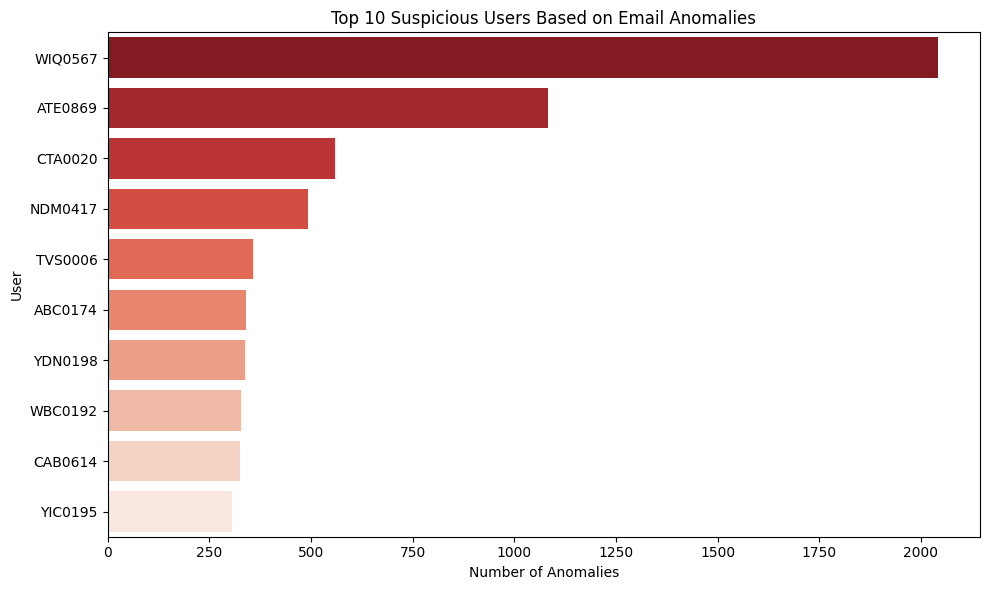

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare the data
top_users = user_anomalies.head(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=top_users, x='anomaly', y='user', palette='Reds_r')
plt.xlabel("Number of Anomalies")
plt.ylabel("User")
plt.title("Top 10 Suspicious Users Based on Email Anomalies")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import numpy as np

# Select features
features = ['hour', 'to_count', 'cc_count', 'bcc_count', 'size', 'attachments',
            'user_encoded', 'O', 'C', 'E', 'A', 'N']
X = merged_df[features].fillna(0)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit Nearest Neighbors model
nn = NearestNeighbors(n_neighbors=5, algorithm='auto', n_jobs=-1)
nn.fit(X_scaled)

# Get distances to k-th neighbor
distances, _ = nn.kneighbors(X_scaled)
outlier_scores = distances.mean(axis=1)

# Choose a threshold (top 5% as anomalies)
threshold = np.percentile(outlier_scores, 95)
merged_df['knn_anomaly'] = (outlier_scores > threshold).astype(int)

# Result: 1 = anomaly, 0 = normal
print(merged_df['knn_anomaly'].value_counts())


knn_anomaly
0    2498480
1     131499
Name: count, dtype: int64


In [15]:
merged_df['both_anomaly'] = (merged_df['anomaly'] & merged_df['knn_anomaly'])
print("Anomalies detected by both models:", merged_df['both_anomaly'].sum())


Anomalies detected by both models: 21273


In [16]:
suspicious = merged_df[merged_df['both_anomaly'] == 1]
suspicious[['user', 'hour', 'size', 'to', 'from']].head(10)


,user,hour,size,to,from
37,NWK0215,8,17588,Hedy_Lopez@bellsouth.net;Tasha_Sanchez@optonli...,Noelani.W.Kennedy@optonline.net
63,YIC0195,8,27637,Cole.Aaron.Mcfarland@dtaa.com;August.Armando.E...,Yolanda.Idona.Crosby@dtaa.com
133,BDI0533,11,49979,Macon.Joseph.Morrison@dtaa.com;Sawyer.Arden.Pu...,Bruno.Donovan.Ingram@dtaa.com
241,IRM0931,14,20800,MacKensie.Grant@aol.com;DHM736@earthlink.net,IRM1@msn.com
353,CMB0912,7,17702,Valentine.Elton.Britt@dtaa.com;Bruce.Sawyer.Ba...,Caleb.Mason.Ball@dtaa.com
364,CMB0912,7,11600,Bruce.Sawyer.Barrera@dtaa.com;Hadley.Leandra.M...,Caleb.Mason.Ball@dtaa.com
461,AJR0319,10,27060,Cochran_Sloane@charter.net;AMR5@earthlink.net;...,AJR5@charter.net
484,BVC0790,10,18408,Wing.Noah.Bonner@dtaa.com;Gray.Mason.Fulton@dt...,Blythe.Veda.Cooke@dtaa.com
609,MCD0125,14,41130,Jin.Jonathan.Buckley@dtaa.com;Jaden.Kylan.Buck...,Mallory.Charissa.Dixon@dtaa.com
632,FKK0055,15,46387,Sarah.Imelda.Juarez@dtaa.com;Summer.Leilani.Bo...,Farrah.Kim.Keith@dtaa.com


from matplotlib import pyplot as plt
_df_0['hour'].plot(kind='hist', bins=20, title='hour')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['size'].plot(kind='hist', bins=20, title='size')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='hour', y='size', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['hour'].plot(kind='line', figsize=(8, 4), title='hour')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['size'].plot(kind='line', figsize=(8, 4), title='size')
plt.gca().spines[['top', 'right']].set_visible(False)

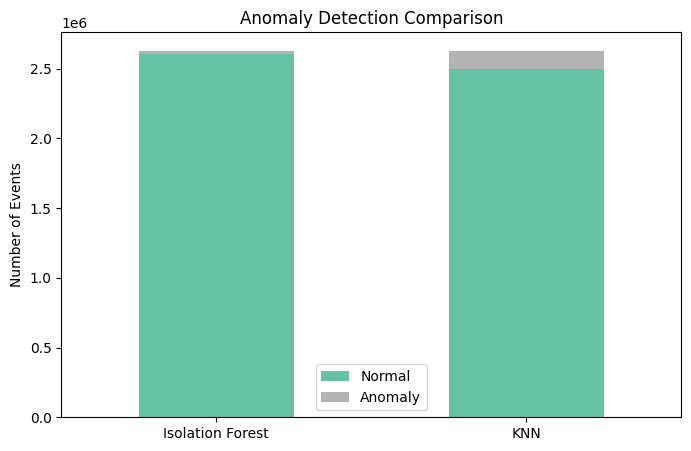

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count anomalies
iso_counts = merged_df['anomaly'].value_counts().sort_index()
knn_counts = merged_df['knn_anomaly'].value_counts().sort_index()

# Create a DataFrame to compare
compare_df = pd.DataFrame({
    'Isolation Forest': iso_counts,
    'KNN': knn_counts
}).T
compare_df.columns = ['Normal', 'Anomaly']

# Bar plot: Overall anomaly count comparison
compare_df.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title("Anomaly Detection Comparison")
plt.ylabel("Number of Events")
plt.xticks(rotation=0)
plt.show()


In [18]:
# Add column to show where both agree
merged_df['both_anomaly'] = (merged_df['anomaly'] & merged_df['knn_anomaly'])

# Count overlap
overlap = merged_df['both_anomaly'].sum()
print(f"✅ Anomalies detected by BOTH models: {overlap}")

# Breakdown
both_anomalies = merged_df[merged_df['both_anomaly'] == 1]
only_knn = merged_df[(merged_df['knn_anomaly'] == 1) & (merged_df['anomaly'] == 0)]
only_iso = merged_df[(merged_df['anomaly'] == 1) & (merged_df['knn_anomaly'] == 0)]


✅ Anomalies detected by BOTH models: 21273


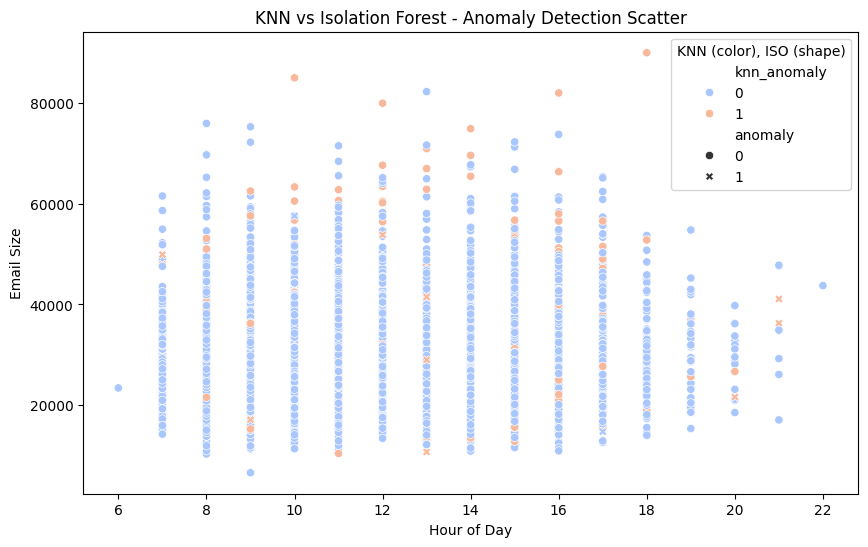

In [19]:
# Sample for plotting
plot_df = merged_df.sample(5000, random_state=42)

# Scatter plot: Email size vs hour
plt.figure(figsize=(10,6))
sns.scatterplot(data=plot_df, x='hour', y='size', hue='knn_anomaly', style='anomaly', palette='coolwarm')
plt.title("KNN vs Isolation Forest - Anomaly Detection Scatter")
plt.xlabel("Hour of Day")
plt.ylabel("Email Size")
plt.legend(title="KNN (color), ISO (shape)")
plt.show()
